In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
content = pd.read_csv('Content.csv', index_col=0)
reaction = pd.read_csv('Reactions.csv', index_col=0)
reaction['Datetime'] = pd.to_datetime(reaction['Datetime'])
reaction_type = pd.read_csv('ReactionTypes.csv', index_col=0)
profile = pd.read_csv('Profile.csv', index_col=0)
session = pd.read_csv('Session.csv', index_col=0)

In [3]:
# EDA of all datasets
display(content.info())
display(reaction.info())
display(reaction_type.info())
display(profile.info())
display(session.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Content ID  1000 non-null   object
 1   User ID     1000 non-null   object
 2   Type        1000 non-null   object
 3   Category    1000 non-null   object
 4   URL         801 non-null    object
dtypes: object(5)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 25553 entries, 0 to 25552
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Content ID  25553 non-null  object        
 1   User ID     22534 non-null  object        
 2   Type        24573 non-null  object        
 3   Datetime    25553 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 998.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Type       16 non-null     object
 1   Sentiment  16 non-null     object
 2   Score      16 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 512.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   User ID    500 non-null    object
 1   Interests  500 non-null    object
 2   Age        500 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User ID   500 non-null    object
 1   Device    500 non-null    object
 2   Duration  500 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


None

In [4]:
# drop url column from content dataset
content.drop('URL', axis=1, inplace=True)

# if reaction type is not present in reaction dataset, then drop it
reaction = reaction[reaction['Type'].isin(reaction_type['Type'])]


In [5]:
# Get all unique interests from the profile dataset
unique_interests = []
for interests in profile['Interests']:
    interests_list = interests.strip("[]").replace("'", "").split(", ")
    # if interest is not a number then append it to the list
    for interest in interests_list:
        if not interest.isdigit():
            unique_interests.append(interest)
unique_interests = list(set(unique_interests))
display(unique_interests)


['travel',
 'culture',
 'cooking',
 'technology',
 'education',
 'public speaking',
 'soccer',
 'veganism',
 'food',
 'dogs',
 'science',
 'fitness',
 'studying',
 'tennis',
 'healthy eating',
 'animals']

In [6]:
# Get the count of all unique interests in the profile dataset stored in a dictionary
unique_interests_count = {}
for interests in profile['Interests']:
    interests_list = interests.strip("[]").replace("'", "").split(", ")
    for interest in interests_list:
        if not interest.isdigit():
            if interest not in unique_interests_count:
                unique_interests_count[interest] = 1
            else:
                unique_interests_count[interest] += 1
# Print the count of unique interests
print(unique_interests_count)
# Calculate the total number of interests in the unique_interests_count dictionary
total_interests = sum(unique_interests_count.values())
print(total_interests)
# Calculate the percentage of each interest
for interest in unique_interests_count:
    unique_interests_count[interest] = round(
        (unique_interests_count[interest]/total_interests), 2)
# Print the percentage of each interest
print(unique_interests_count)

{'tennis': 73, 'fitness': 70, 'cooking': 77, 'animals': 85, 'travel': 70, 'technology': 63, 'culture': 78, 'veganism': 78, 'education': 77, 'healthy eating': 84, 'food': 90, 'public speaking': 92, 'science': 92, 'studying': 69, 'soccer': 90, 'dogs': 67}
1255
{'tennis': 0.06, 'fitness': 0.06, 'cooking': 0.06, 'animals': 0.07, 'travel': 0.06, 'technology': 0.05, 'culture': 0.06, 'veganism': 0.06, 'education': 0.06, 'healthy eating': 0.07, 'food': 0.07, 'public speaking': 0.07, 'science': 0.07, 'studying': 0.05, 'soccer': 0.07, 'dogs': 0.05}


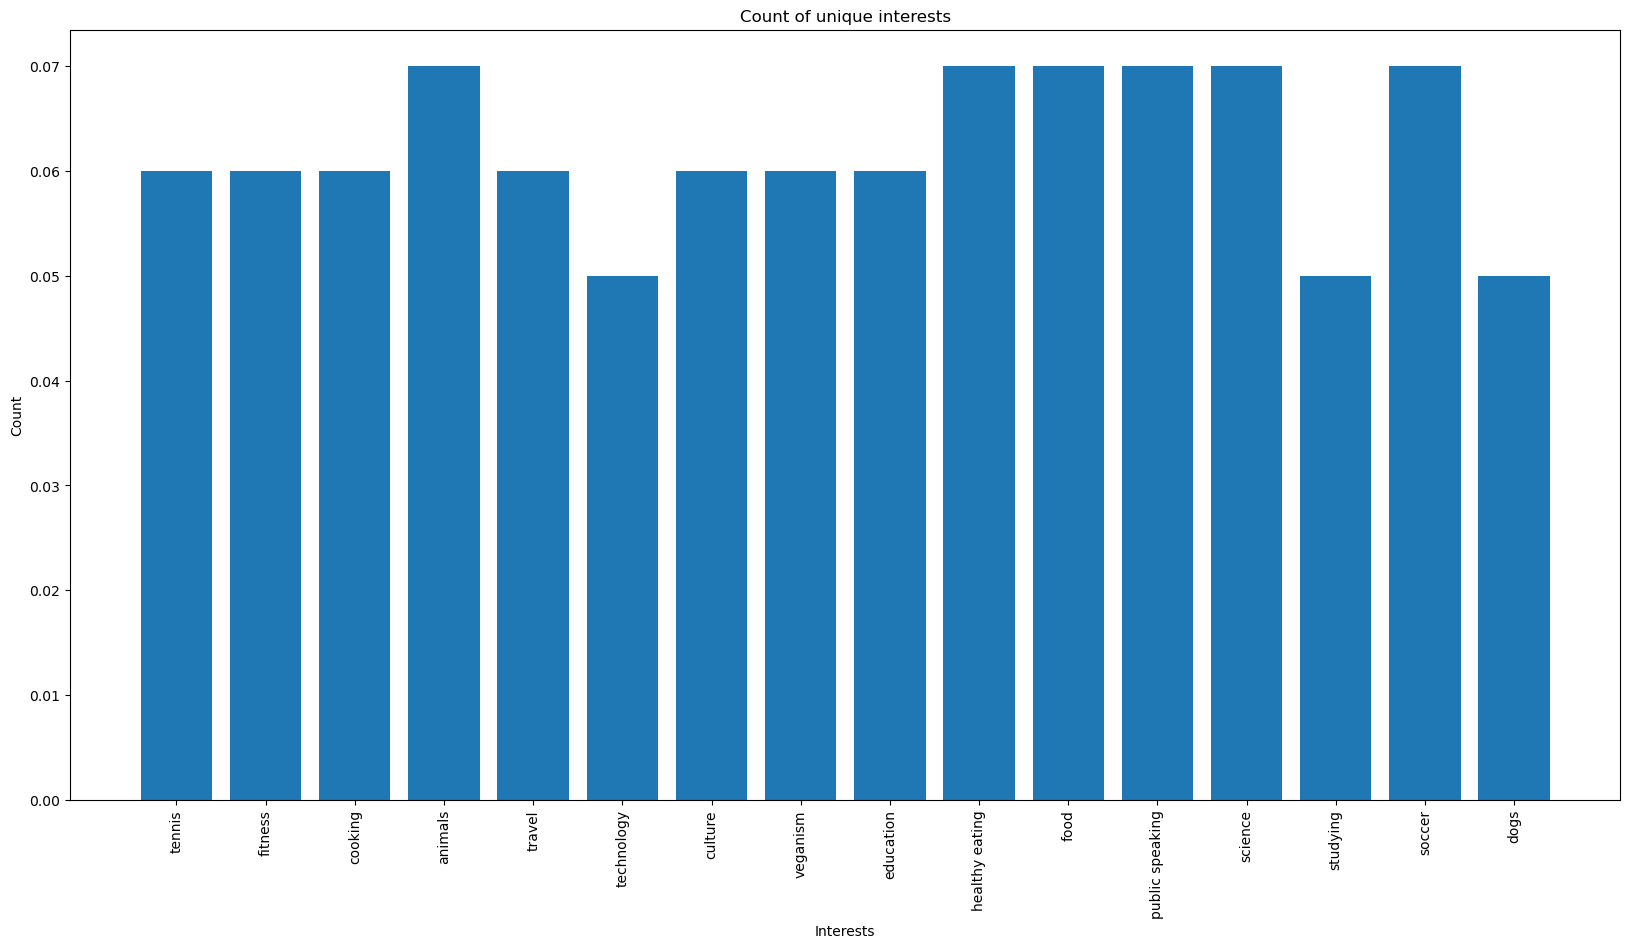

In [7]:
# create a bar chart for the unique interests count
plt.figure(figsize=(20, 10))
plt.bar(unique_interests_count.keys(), unique_interests_count.values())
plt.xticks(rotation=90)
plt.xlabel('Interests')
plt.ylabel('Count')
plt.title('Count of unique interests')
plt.show()

In [8]:
# remove special characters but allow spaces from Category column in content dataset
display(content['Category'].unique())
content['Category'] = content['Category'].str.replace('"', '')
content['Category'] = content['Category'].str.lower()
display(content['Category'].unique())
display(content['Category'].value_counts())
display(content['Category'].unique().shape[0])

array(['Studying', 'healthy eating', 'technology', 'food', 'cooking',
       'dogs', 'soccer', 'public speaking', 'science', 'tennis', 'travel',
       'fitness', 'education', 'studying', 'veganism', 'Animals',
       'animals', 'culture', '"culture"', 'Fitness', '"studying"',
       'Veganism', '"animals"', 'Travel', '"soccer"', 'Education',
       '"dogs"', 'Technology', 'Soccer', '"tennis"', 'Culture', '"food"',
       'Food', '"technology"', 'Healthy Eating', '"cooking"', 'Science',
       '"public speaking"', '"veganism"', 'Public Speaking', '"science"'],
      dtype=object)

array(['studying', 'healthy eating', 'technology', 'food', 'cooking',
       'dogs', 'soccer', 'public speaking', 'science', 'tennis', 'travel',
       'fitness', 'education', 'veganism', 'animals', 'culture'],
      dtype=object)

Category
technology         73
animals            72
travel             69
science            68
culture            67
fitness            66
food               64
soccer             64
healthy eating     62
cooking            61
tennis             59
education          59
studying           58
dogs               58
public speaking    50
veganism           50
Name: count, dtype: int64

16

In [9]:
# Create a dictionary of all unique categories and their count for the content dataset
unique_categories = {}
for category in content['Category']:
    if category not in unique_categories:
        unique_categories[category] = 1
    else:
        unique_categories[category] += 1
# Print the dictionary
print(unique_categories)

# Calculate the total number of categories in the unique_categories dictionary
total_categories = sum(unique_categories.values())
print(total_categories)
# Calculate the percentage of each interest
for category in unique_categories:
    unique_categories[category] = round(
        (unique_categories[category]/total_categories), 2)
# Print the percentage of each interest
print(unique_categories)

{'studying': 58, 'healthy eating': 62, 'technology': 73, 'food': 64, 'cooking': 61, 'dogs': 58, 'soccer': 64, 'public speaking': 50, 'science': 68, 'tennis': 59, 'travel': 69, 'fitness': 66, 'education': 59, 'veganism': 50, 'animals': 72, 'culture': 67}
1000
{'studying': 0.06, 'healthy eating': 0.06, 'technology': 0.07, 'food': 0.06, 'cooking': 0.06, 'dogs': 0.06, 'soccer': 0.06, 'public speaking': 0.05, 'science': 0.07, 'tennis': 0.06, 'travel': 0.07, 'fitness': 0.07, 'education': 0.06, 'veganism': 0.05, 'animals': 0.07, 'culture': 0.07}


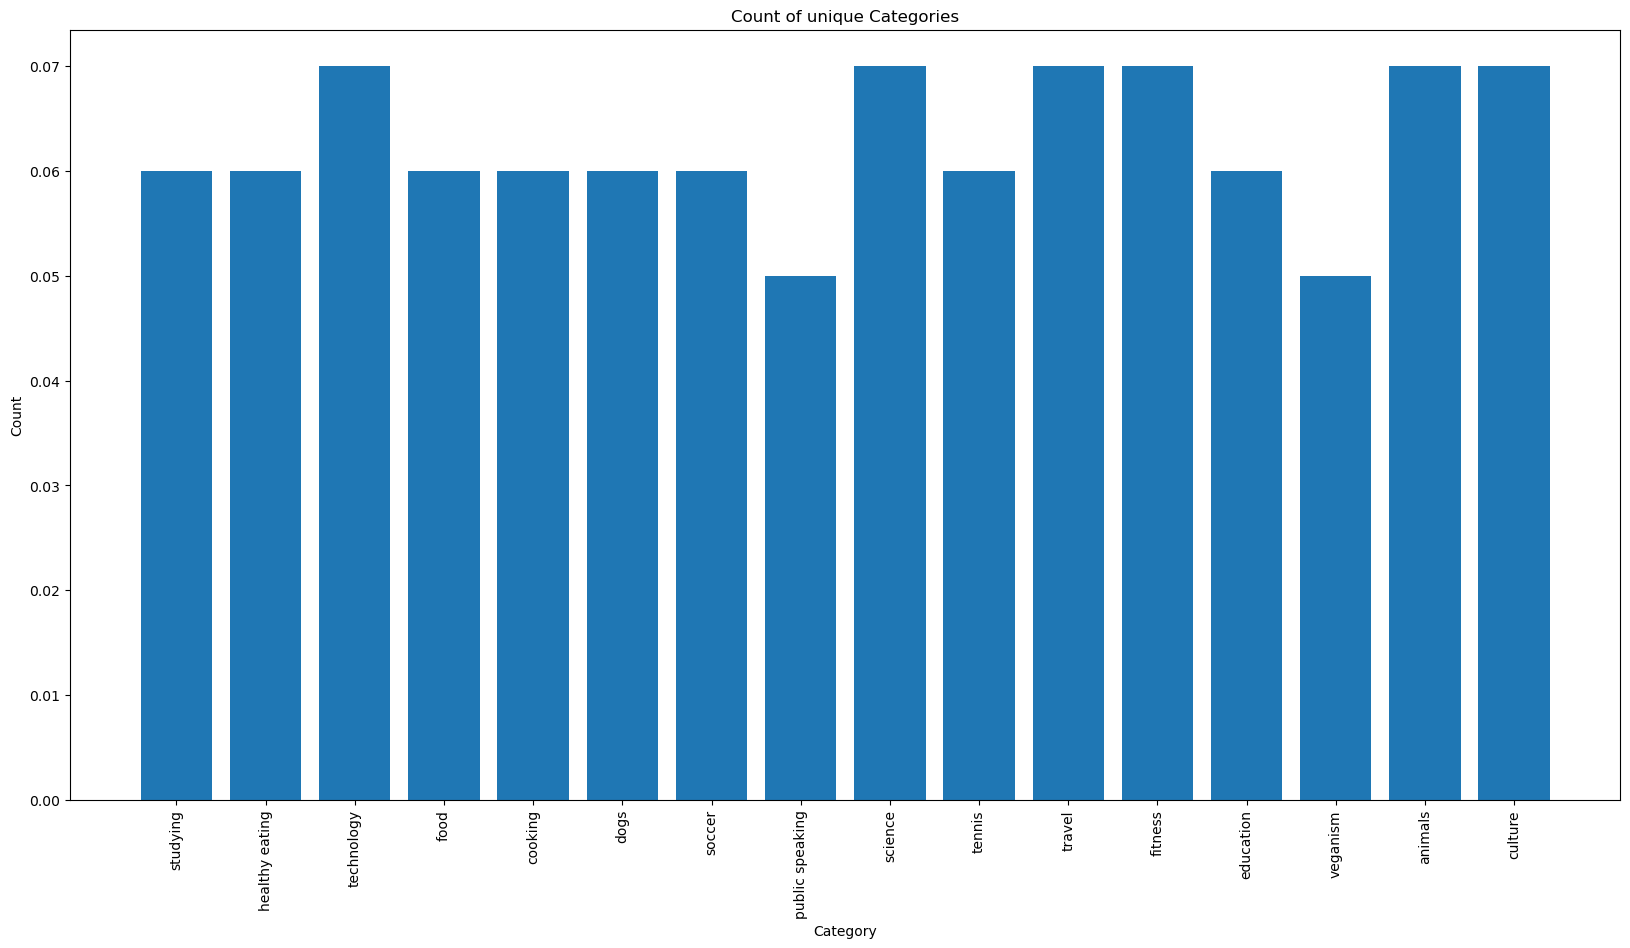

In [10]:
# create a bar chart for the unique categories count
plt.figure(figsize=(20, 10))
plt.bar(unique_categories.keys(), unique_categories.values())
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of unique Categories')
plt.show()

,Stated,Actual
tennis,0.06,0.06
fitness,0.06,0.07
cooking,0.06,0.06
animals,0.07,0.07
travel,0.06,0.07
technology,0.05,0.07
culture,0.06,0.07
veganism,0.06,0.05
education,0.06,0.06
healthy eating,0.07,0.06


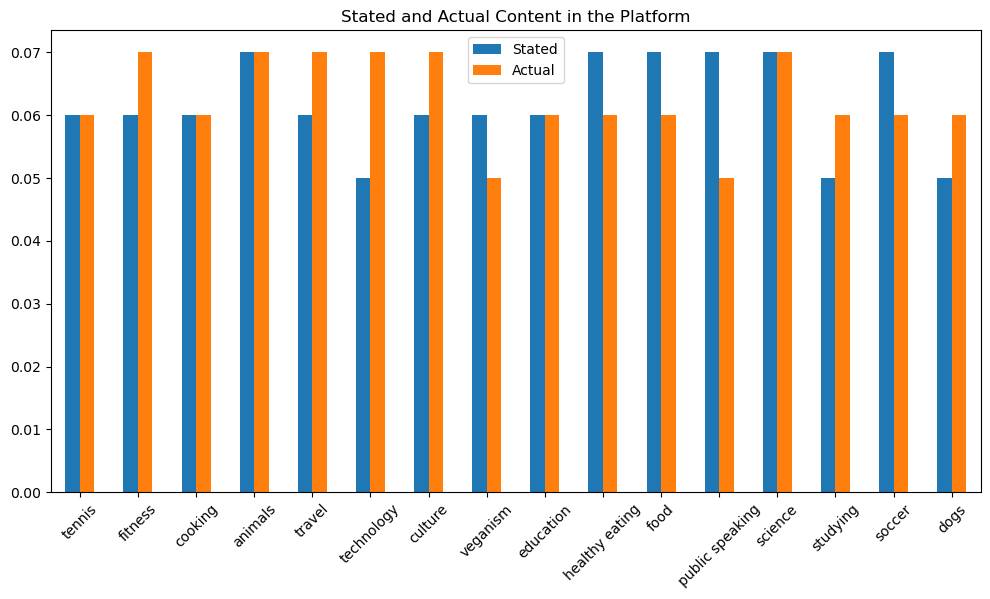

In [11]:
# Convert unique_interests_count to dataframe
df_unique_interests_count = pd.DataFrame.from_dict(unique_interests_count, orient='index', columns=['Stated'])

# Convert unique_categories to dataframe
df_unique_categories = pd.DataFrame.from_dict(unique_categories, orient='index', columns=['Actual'])

merged_df = pd.merge(df_unique_interests_count, df_unique_categories, left_index=True, right_index=True)
display(merged_df)

merged_df.plot(kind='bar', figsize=(12, 6))
plt.title("Stated and Actual Content in the Platform")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Create a new dataset with the count of entries for each category per user id in the content dataset
content_category = content[['Content ID', 'User ID', 'Category']].groupby(['User ID', 'Category']).count().unstack().reset_index()
content_category.drop('User ID', axis=1, inplace=True)
# fill NaN values with 0
content_category.fillna(0, inplace=True)
display(content_category)
content_category.to_csv('content_category.csv') # save the dataset

Content ID                                              \
Category    animals cooking culture dogs education fitness food   
0               0.0     0.0     0.0  0.0       0.0     0.0  0.0   
1               0.0     0.0     0.0  0.0       0.0     0.0  0.0   
2               0.0     1.0     0.0  0.0       0.0     0.0  0.0   
3               0.0     0.0     1.0  0.0       0.0     0.0  0.0   
4               0.0     0.0     0.0  0.0       0.0     0.0  0.0   
..              ...     ...     ...  ...       ...     ...  ...   
441             0.0     0.0     0.0  0.0       0.0     0.0  0.0   
442             0.0     0.0     0.0  0.0       0.0     1.0  0.0   
443             0.0     0.0     0.0  0.0       0.0     1.0  0.0   
444             0.0     0.0     0.0  0.0       0.0     1.0  0.0   
445             0.0     0.0     0.0  0.0       0.0     1.0  0.0   

                                                                            \
Category healthy eating public speaking science soccer studying technology   
0                   0.0             2.0     0.0    0.0      0.0        0.0   
1                   0.0             0.0     0.0    0.0      0.0        1.0   
2                   0.0             0.0     0.0    0.0      0.0        0.0   
3                   0.0             0.0     0.0    1.0      0.0        0.0   
4                   1.0             0.0     0.0    3.0      0.0        1.0   
..                  ...             ...     ...    ...      ...        ...   
441                 0.0             0.0     0.0    0.0      0.0        1.0   
442                 1.0             0.0     0.0    0.0      0.0        0.0   
443                 0.0             0.0     0.0    2.0      0.0        0.0   
444                 1.0             0.0     0.0    0.0      0.0        0.0   
445                 0.0             0.0     0.0    0.0      0.0        0.0   

                                 
Category tennis travel veganism  
0           0.0    0.0      0.0  
1           0.0    1.0      0.0  
2           1.0    0.0      0.0  
3           0.0    0.0      0.0  
4           0.0    0.0      0.0  
..          ...    ...      ...  
441         0.0    0.0      0.0  
442         1.0    0.0      0.0  
443         1.0    0.0      0.0  
444         0.0    0.0      0.0  
445         0.0    0.0      0.0  

[446 rows x 16 columns]

In [13]:

# Create a new dataset with the count of entries for each category per user id in the reaction dataset
#reaction_category = content.merge(reaction, on='Content ID', how='inner')
#reaction_category = reaction[['Content ID', 'User ID', 'Category']].groupby(['User ID', 'Category']).count().unstack().reset_index()
#content_category.drop('User ID', axis=1, inplace=True)
# fill NaN values with 0
#content_category.fillna(0, inplace=True)
#display(reaction_category)
#reaction_category.to_csv('content_category.csv') # save the dataset

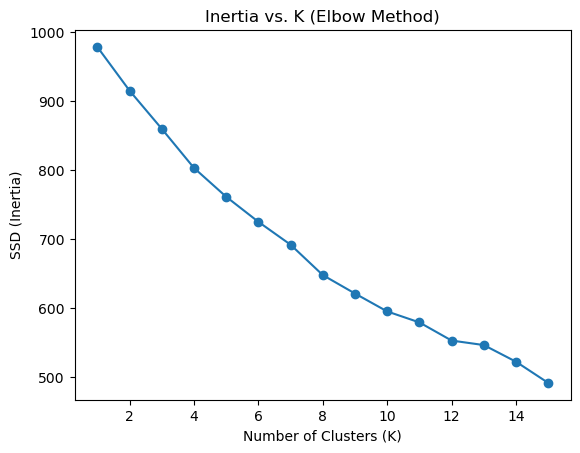

In [14]:
k_values = range(1, 16)
scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(content_category)
    scores.append(kmeans.inertia_)
plt.plot(k_values, scores, marker='o')
plt.title("Inertia vs. K (Elbow Method)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSD (Inertia)")
plt.show()

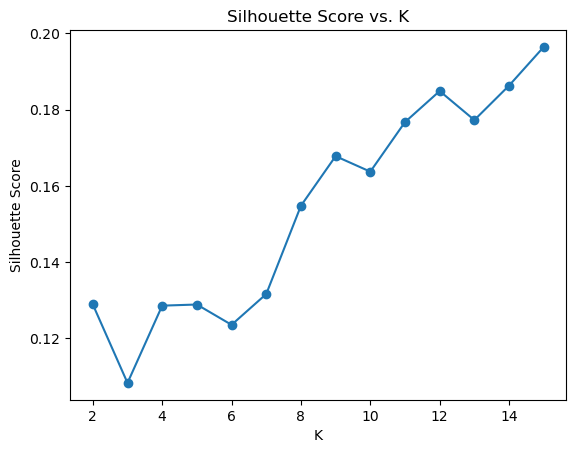

In [15]:
k_values = range(2, 16)
scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(content_category)
    scores.append(silhouette_score(content_category, kmeans.labels_))
plt.plot(k_values, scores, marker='o')
plt.title("Silhouette Score vs. K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

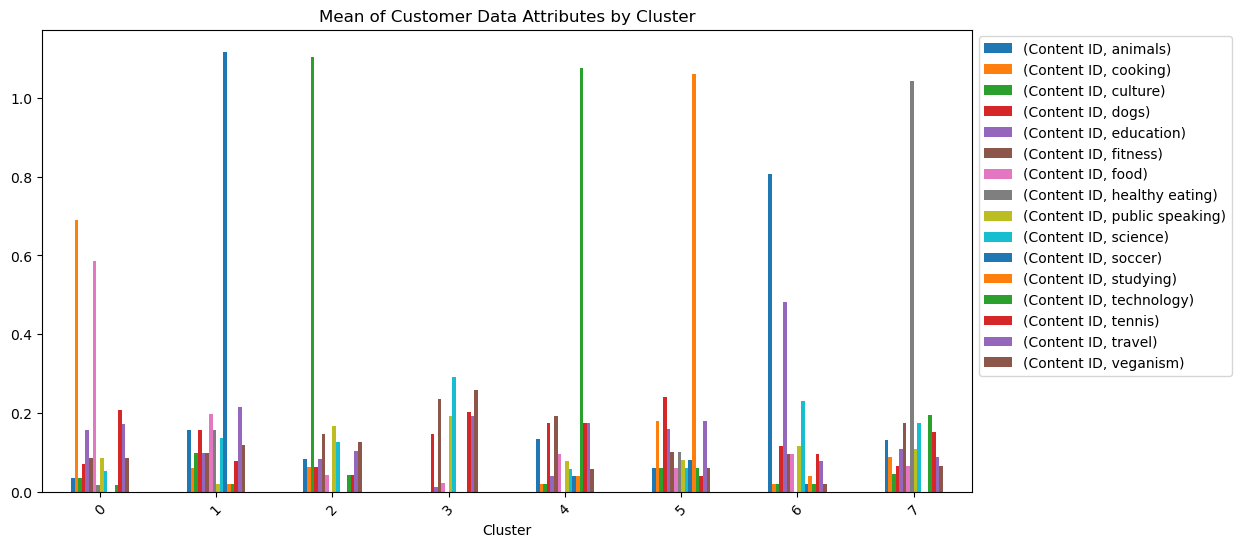

In [16]:
# K-means clustering with k=8 on the scaled data
kmeans = KMeans(n_clusters=8, random_state=42).fit(content_category)
labels = kmeans.labels_
content_category['Cluster'] = labels

# Plotting the mean of each attribute by cluster

ax = content_category.groupby('Cluster').mean().plot(kind='bar', figsize=(12, 6))
plt.title("Mean of Customer Data Attributes by Cluster")
plt.xticks(rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [17]:
# Create a dataframe of the count of rows in each cluster in the content_category dataset
cluster_count = pd.DataFrame(content_category['Cluster'].value_counts()).reset_index()
cluster_count.columns = ['Cluster', 'Count']
# Create a new column of the percentage of each cluster out of the total count of rows
cluster_count['Percentage'] = round(
    (cluster_count['Count']/cluster_count['Count'].sum()), 2)
display(cluster_count)


,Cluster,Count,Percentage
0,3,89,0.20
1,0,58,0.13
2,4,52,0.12
3,6,52,0.12
4,1,51,0.11
5,5,50,0.11
6,2,48,0.11
7,7,46,0.10


In [18]:
# Reshape the DataFrame using melt
#melted_df = content_category.groupby('Cluster').mean().reset_index().melt(id_vars='Cluster')
#display(melted_df)
# Plotting the mean of each attribute by cluster using Seaborn
#plt.figure(figsize=(12, 6))
#sns.barplot(x='Cluster', y='value', hue='Category', data=melted_df)
#plt.title("Mean of Customer Data Attributes by Cluster")
#plt.xticks(rotation=45)
#plt.show()

In [19]:
# Merge reactions with content on Content ID and only keep the Category column from content
reaction_category = reaction.merge(content[['Content ID', 'Category']], on='Content ID', how='left').merge(reaction_type[['Type','Sentiment']], on='Type', how='left')
reaction_category.drop(['Datetime'], axis=1, inplace=True)
display(reaction_category)

# Delete duplicate rows where Content ID and User ID are the same
reaction_category.drop_duplicates(subset=['Content ID', 'User ID'], inplace=True)
#display(reaction_category)

# 
reactions_per_category = reaction_category[['User ID', 'Category']].groupby(['User ID', 'Category']).size().unstack()
reactions_per_category.fillna(0, inplace=True)
display(reactions_per_category)

reaction_category.drop(['User ID','Type'], axis=1, inplace=True)
display(reaction_category)
# Create a new dataset with the count of entries for each Sentiment Value per Content ID in the reaction_category dataset
reaction_sentiment = reaction_category[['Content ID', 'Sentiment']].groupby(['Content ID', 'Sentiment']).size().unstack().reset_index()
reaction_sentiment.fillna(0, inplace=True)
display(reaction_sentiment)
# Create a new dataset with the count of entries for each Sentiment Value per Category in the reaction_category dataset
reaction_category_sentiment = reaction_category[['Category', 'Sentiment']].groupby(['Category', 'Sentiment']).size().unstack().reset_index()
reaction_category_sentiment.fillna(0, inplace=True)
display(reaction_category_sentiment)


,Content ID,User ID,Type,Category,Sentiment
0,97522e57-d9ab-4bd6-97bf-c24d952602d2,5d454588-283d-459d-915d-c48a2cb4c27f,disgust,studying,negative
1,97522e57-d9ab-4bd6-97bf-c24d952602d2,92b87fa5-f271-43e0-af66-84fac21052e6,dislike,studying,negative
2,97522e57-d9ab-4bd6-97bf-c24d952602d2,163daa38-8b77-48c9-9af6-37a6c1447ac2,scared,studying,negative
3,97522e57-d9ab-4bd6-97bf-c24d952602d2,34e8add9-0206-47fd-a501-037b994650a2,disgust,studying,negative
4,97522e57-d9ab-4bd6-97bf-c24d952602d2,9b6d35f9-5e15-4cd0-a8d7-b1f3340e02c4,interested,studying,positive
...,...,...,...,...,...
24568,75d6b589-7fae-4a6d-b0d0-752845150e56,80c9ce48-46f9-4f5e-b3ca-3b698fc2e949,dislike,technology,negative
24569,75d6b589-7fae-4a6d-b0d0-752845150e56,2bd9c167-e06c-47c1-a978-3403d6724606,intrigued,technology,positive
24570,75d6b589-7fae-4a6d-b0d0-752845150e56,NaN,interested,technology,positive
24571,75d6b589-7fae-4a6d-b0d0-752845150e56,5ffd8b51-164e-47e2-885e-8b8c46eb63ed,worried,technology,negative


Category,animals,cooking,culture,dogs,education,fitness,food,healthy eating,public speaking,science,soccer,studying,technology,tennis,travel,veganism
User ID,,,,,,,,,,,,,,,,
002cd824-10f2-447c-8d1c-940325a1cdf4,4.0,1.0,6.0,2.0,2.0,4.0,4.0,1.0,2.0,2.0,2.0,5.0,6.0,4.0,2.0,1.0
007a1366-a46f-40f1-9ba5-01245aeaf20f,2.0,0.0,2.0,2.0,5.0,2.0,2.0,6.0,2.0,2.0,2.0,2.0,3.0,0.0,1.0,2.0
03e3a23a-a77a-41da-9ecd-3f2ff9e5bc90,5.0,3.0,2.0,2.0,2.0,1.0,5.0,3.0,0.0,1.0,3.0,3.0,4.0,1.0,2.0,1.0
04e52602-e370-4a99-bfda-f0c1655058da,2.0,1.0,5.0,1.0,3.0,3.0,3.0,4.0,3.0,0.0,1.0,2.0,1.0,4.0,3.0,5.0
052faed2-37ac-4a2c-ba6f-2657322e4fa5,5.0,3.0,4.0,2.0,2.0,1.0,3.0,5.0,1.0,4.0,3.0,3.0,7.0,2.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe15963d-0a77-4247-9bc6-04e146b826b2,3.0,6.0,4.0,1.0,4.0,2.0,7.0,3.0,1.0,3.0,4.0,0.0,6.0,2.0,3.0,2.0
fe1c151b-1a95-43fa-9a4c-f3214adba852,6.0,3.0,3.0,1.0,1.0,1.0,3.0,4.0,3.0,4.0,7.0,1.0,6.0,4.0,0.0,2.0
fe224147-e893-4178-b46e-b12f22bd7ed1,6.0,4.0,2.0,6.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0,4.0,0.0,0.0,3.0,1.0


,Content ID,Category,Sentiment
0,97522e57-d9ab-4bd6-97bf-c24d952602d2,studying,negative
1,97522e57-d9ab-4bd6-97bf-c24d952602d2,studying,negative
2,97522e57-d9ab-4bd6-97bf-c24d952602d2,studying,negative
3,97522e57-d9ab-4bd6-97bf-c24d952602d2,studying,negative
4,97522e57-d9ab-4bd6-97bf-c24d952602d2,studying,positive
...,...,...,...
24568,75d6b589-7fae-4a6d-b0d0-752845150e56,technology,negative
24569,75d6b589-7fae-4a6d-b0d0-752845150e56,technology,positive
24570,75d6b589-7fae-4a6d-b0d0-752845150e56,technology,positive
24571,75d6b589-7fae-4a6d-b0d0-752845150e56,technology,negative


Sentiment,Content ID,negative,neutral,positive
0,004e820e-49c3-4ba2-9d02-62db0065410c,0.0,0.0,1.0
1,00d0cdf9-5919-4102-bf84-ebde253c3cd2,13.0,4.0,24.0
2,01396602-c759-4a17-90f0-8f9b3ca11b30,14.0,3.0,19.0
3,019b61f4-926c-438e-adaf-6119c5eab752,4.0,2.0,7.0
4,01ab84dd-6364-4236-abbb-3f237db77180,1.0,0.0,0.0
...,...,...,...,...
957,fdca8d15-966b-4825-8133-1fafc5c1f9fc,8.0,2.0,16.0
958,fe06b730-b1f8-4f55-af1a-52487d8f1ec6,9.0,3.0,11.0
959,fea8d77c-fd0b-4678-868f-fbae567642f3,1.0,1.0,4.0
960,fea9077f-2fe7-43bd-aaef-dc2619988d94,1.0,3.0,2.0


Sentiment,Category,negative,neutral,positive
0,animals,571,213,961
1,cooking,502,171,868
2,culture,486,195,871
3,dogs,378,175,690
4,education,399,172,748
5,fitness,411,158,726
6,food,503,190,873
7,healthy eating,484,199,908
8,public speaking,334,134,658
9,science,495,219,950
